In [2]:
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt

In [33]:
# Data source: https://www.kaggle.com/datasets/gauthamp10/google-playstore-apps
path = os.getcwd() + "/data/Google-Playstore.csv"
df = pd.read_csv(path)
print(df.shape)

(2312944, 24)


In [33]:
def sample_df(df, sample_size=None, fraction=None, strat_column=None, random_state=123):
    """
    Single function to sample from a pandas DataFrame in several ways.
    Input:
    - Give sample_size or fraction.
    - Optional: Specify a stratification column.
    Note that when using stratification, sample size needs to be converted to fraction as well.
    This leads to rounding errors in the total sample size that are not adressed in the current versions.

    Output: A subset of the original DataFrame
    """
    if not ((sample_size != None) ^ (fraction!= None)):
        raise Exception("Specify one of arguments sample_size, fraction.")
    
    #Convert sample size to fraction
    if sample_size != None:
        fraction = sample_size / df.shape[0]

    if strat_column in df.columns:
        #Note that if sample_size was specified this is currently imprecise
        s_df = df.groupby(strat_column).apply(lambda x: x.sample(frac=fraction, replace=False, weights=None, random_state=random_state, axis=None, ignore_index=False))
    elif strat_column != None:
        raise Exception("strat_column not in df columns")
    else:
        s_df = df.sample(frac=fraction, replace=False, weights=None, random_state=random_state, axis=None, ignore_index=False)
    return s_df

In [8]:
print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 806021 entries, 1 to 2312943
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   App Name                     806021 non-null  object        
 1   App Id                       806021 non-null  object        
 2   Category                     806021 non-null  object        
 3   Rating                       806021 non-null  float64       
 4   log_Rating Count             806021 non-null  float64       
 5   log_Maximum Installs         806021 non-null  float64       
 6   Free                         806021 non-null  bool          
 7   log_Price                    806021 non-null  float64       
 8   log_Size                     783378 non-null  float64       
 9   Released                     788927 non-null  datetime64[ns]
 10  Last Updated                 806021 non-null  datetime64[ns]
 11  Ad Supported             

,App Name,App Id,Category,Rating,log_Rating Count,log_Maximum Installs,Free,log_Price,log_Size,Released,Last Updated,Ad Supported,In App Purchases,Super Category,Rating Bin,Name Length,Size Cat,Time since last update,Days Release to Last Update
index,,,,,,,,,,,,,,,,,,,
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,1.812913,3.884399,True,0.0,0.591065,2020-05-21,2021-05-06,True,False,Other,Moderate,19,Known,0,350.0
6,unlimited 4G data prank free app,getfreedata.superfatiza.unlimitedjiodataprank,Libraries & Demo,4.5,1.113943,3.409595,True,0.0,0.544068,2019-09-23,2019-09-27,True,False,Other,Superb,32,Known,2,4.0
7,The Everyday Calendar,com.mozaix.simoneboard,Lifestyle,2.0,1.602060,2.846955,True,0.0,1.230449,2019-06-21,2019-06-21,False,False,Personal & Social,Bad App Yo,21,Known,2,0.0
9,Neon 3d Iron Tech Keyboard Theme,com.ikeyboard.theme.neon_3d.iron.tech,Personalization,4.7,2.914343,4.795421,True,0.0,0.653213,2019-09-22,2020-10-07,True,False,Personal & Social,Superb,32,Known,1,381.0
10,Dodge The Cars!,com.MrScratchEnterprises.CarDogeGame,Racing,4.9,1.748188,2.518514,True,0.0,1.716003,2020-07-30,2020-07-30,False,False,Entertainment,Superb,15,Known,1,0.0
12,桃園機場捷運時刻表 - 捷運轉乘路線快速查詢(支援台北捷運),com.jieapp.taoyuanmetro,Travel & Local,3.9,2.075547,4.577078,True,0.0,0.934498,2018-04-03,2021-06-11,True,False,Other,Bad App Yo,30,Known,0,1165.0
14,Caliway Conductor,com.caliwayconductor.driver,Travel & Local,3.7,3.196729,4.632022,True,0.0,1.477121,2018-09-05,2020-05-30,False,False,Other,Bad App Yo,17,Known,1,633.0
15,Readymade Grocery App,com.ionicfirebaseapp.readymadegroceryuserapp,Food & Drink,4.2,1.230449,3.634880,True,0.0,1.113943,2020-04-05,2021-03-23,False,False,Other,Moderate,21,Known,0,352.0
18,REDMOND Robot,com.grit.redmond,Lifestyle,3.7,2.517196,4.494655,True,0.0,1.851258,2020-07-01,2021-05-26,False,False,Personal & Social,Bad App Yo,14,Known,0,329.0


In [35]:
df = df.drop(['Scraped Time', 'Developer Id', 'Installs', 'Currency', 'Minimum Installs',  #'Size',
'Developer Website', 'Developer Email', 'Privacy Policy', 'Minimum Android', 'Content Rating', 
'Editors Choice'], axis=1)

#This one app had only 1 maximum install but an incredible number of ratings.
df = df[df['App Id'] != 'com.google.android.apps.wellbeing']
df.shape

(2312943, 13)

In [36]:
cat_name = 'Super Category'
df[cat_name] = df['Category']
df[cat_name] = df[cat_name].replace(['Adventure', 'Racing', 'Puzzle', 'Entertainment', 'Arcade', 'Photography', 'Sports', 'Card', 'Trivia', 'Strategy', 'Action', 'Simulation', 'Casino', 'Comics'], 'Entertainment')
df[cat_name] = df[cat_name].replace(['Communication', 'Social', 'Events', 'Dating', 'Role Playing', 'Lifestyle', 'Personalization', 'Medical', 'Health & Fitness', 'Beauty', 'Parenting'], 'Personal & Social')
df[cat_name] = df[cat_name].replace(['Productivity', 'Books & Reference', 'Education', 'Business', 'Educational', 'Finance'], 'Development')
df[cat_name] = df[cat_name].replace(['Casual', 'Tools', 'Libraries & Demo', 'Maps & Navigation', 'Travel & Local', 'Food & Drink', 'Music', 'Auto & Vehicles','Shopping', 'Board', 'Music & Audio', 'News & Magazines', 'Art & Design', 'House & Home', 'Weather', 'Word', 'Video Players & Editors'], 'Other')
df[cat_name] = df[cat_name].astype('category')
df[cat_name].value_counts()

Other                736773
Development          668061
Personal & Social    460998
Entertainment        447111
Name: Super Category, dtype: int64

In [37]:
df['Rating Bin'] = pd.cut(df['Rating'],bins=[0,3.9,4.4,5], labels=['Bad App Yo', 'Moderate', 'Superb'])
# labels=['Bad App Yo', 'Moderate', 'Superb']

In [38]:
df['Rating Bin'].value_counts()

Superb        423015
Bad App Yo    412646
Moderate      394637
Name: Rating Bin, dtype: int64

In [39]:
df['App Name'] = df['App Name'].apply(str)
df['Name Length'] = df['App Name'].apply(len)

In [40]:
#What kind of Size values exist, going by the text part of the string
SizeCats = df['Size'].apply(lambda x: re.findall('([\sA-Za-z]*$)', str(x))[0])
print(SizeCats.value_counts())

#Knowing there are three kinds of known sizes (kb, Mb, Gb) we convert these to Mb
#But because there are also missing values or OS dependent sizes, we store this categorically in an extra column
#(known sizes will be categorized as 'known')
def process_Size(value):
    value = str(value)
    conversion = {'k':0.001, 'M':1.0, 'G':1000.0}
    if value[-1] in conversion.keys():
        value = value.replace(',', '') #added because some 
        size = float(value[:-1]) * conversion[value[-1]]
        category = 'Known'
    else:
        size = None
        category = value
    return (size, category)


temp_df = pd.DataFrame(df['Size'].apply(lambda x: process_Size(x)).tolist(), columns=['Size', 'Size Cat'])
df['Size'] = temp_df['Size'].values
df['Size Cat'] = temp_df['Size Cat'].values
del temp_df
df.shape

M                     2201704
Varies with device      74777
k                       36253
nan                       196
G                          13
Name: Size, dtype: int64


(2312943, 17)

In [41]:
df.isnull().sum()

App Name                  0
App Id                    0
Category                  0
Rating                22883
Rating Count          22883
Maximum Installs          0
Free                      0
Price                     0
Size                  74973
Released              71053
Last Updated              0
Ad Supported              0
In App Purchases          0
Super Category            0
Rating Bin          1082645
Name Length               0
Size Cat                  0
dtype: int64

In [42]:
#Time for some visual exploration
#But first a reload station for data so far
df.to_parquet('data/Google-Playstore-exploration.parquet')

In [53]:
df = pd.read_parquet("data/Google-Playstore-exploration.parquet", engine='fastparquet')

In [44]:
df.head()

,App Name,App Id,Category,Rating,Rating Count,Maximum Installs,Free,Price,Size,Released,Last Updated,Ad Supported,In App Purchases,Super Category,Rating Bin,Name Length,Size Cat
index,,,,,,,,,,,,,,,,,
0,Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,15,True,0.0,10.0,"Feb 26, 2020","Feb 26, 2020",False,False,Entertainment,NaN,7,Known
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64.0,7662,True,0.0,2.9,"May 21, 2020","May 06, 2021",True,False,Other,Moderate,19,Known
2,Vibook,com.doantiepvien.crm,Productivity,0.0,0.0,58,True,0.0,3.7,"Aug 9, 2019","Aug 19, 2019",False,False,Development,NaN,6,Known
3,Smart City Trichy Public Service Vehicles 17UC...,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,19,True,0.0,1.8,"Sep 10, 2018","Oct 13, 2018",True,False,Personal & Social,Superb,50,Known
4,GROW.me,com.horodyski.grower,Tools,0.0,0.0,478,True,0.0,6.2,"Feb 21, 2020","Nov 12, 2018",False,False,Other,NaN,7,Known


In [4]:
# sample from dataframe
from sklearn.model_selection import train_test_split
p_df, s_df = train_test_split(df, test_size=300, random_state=123) #parked and small subset

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


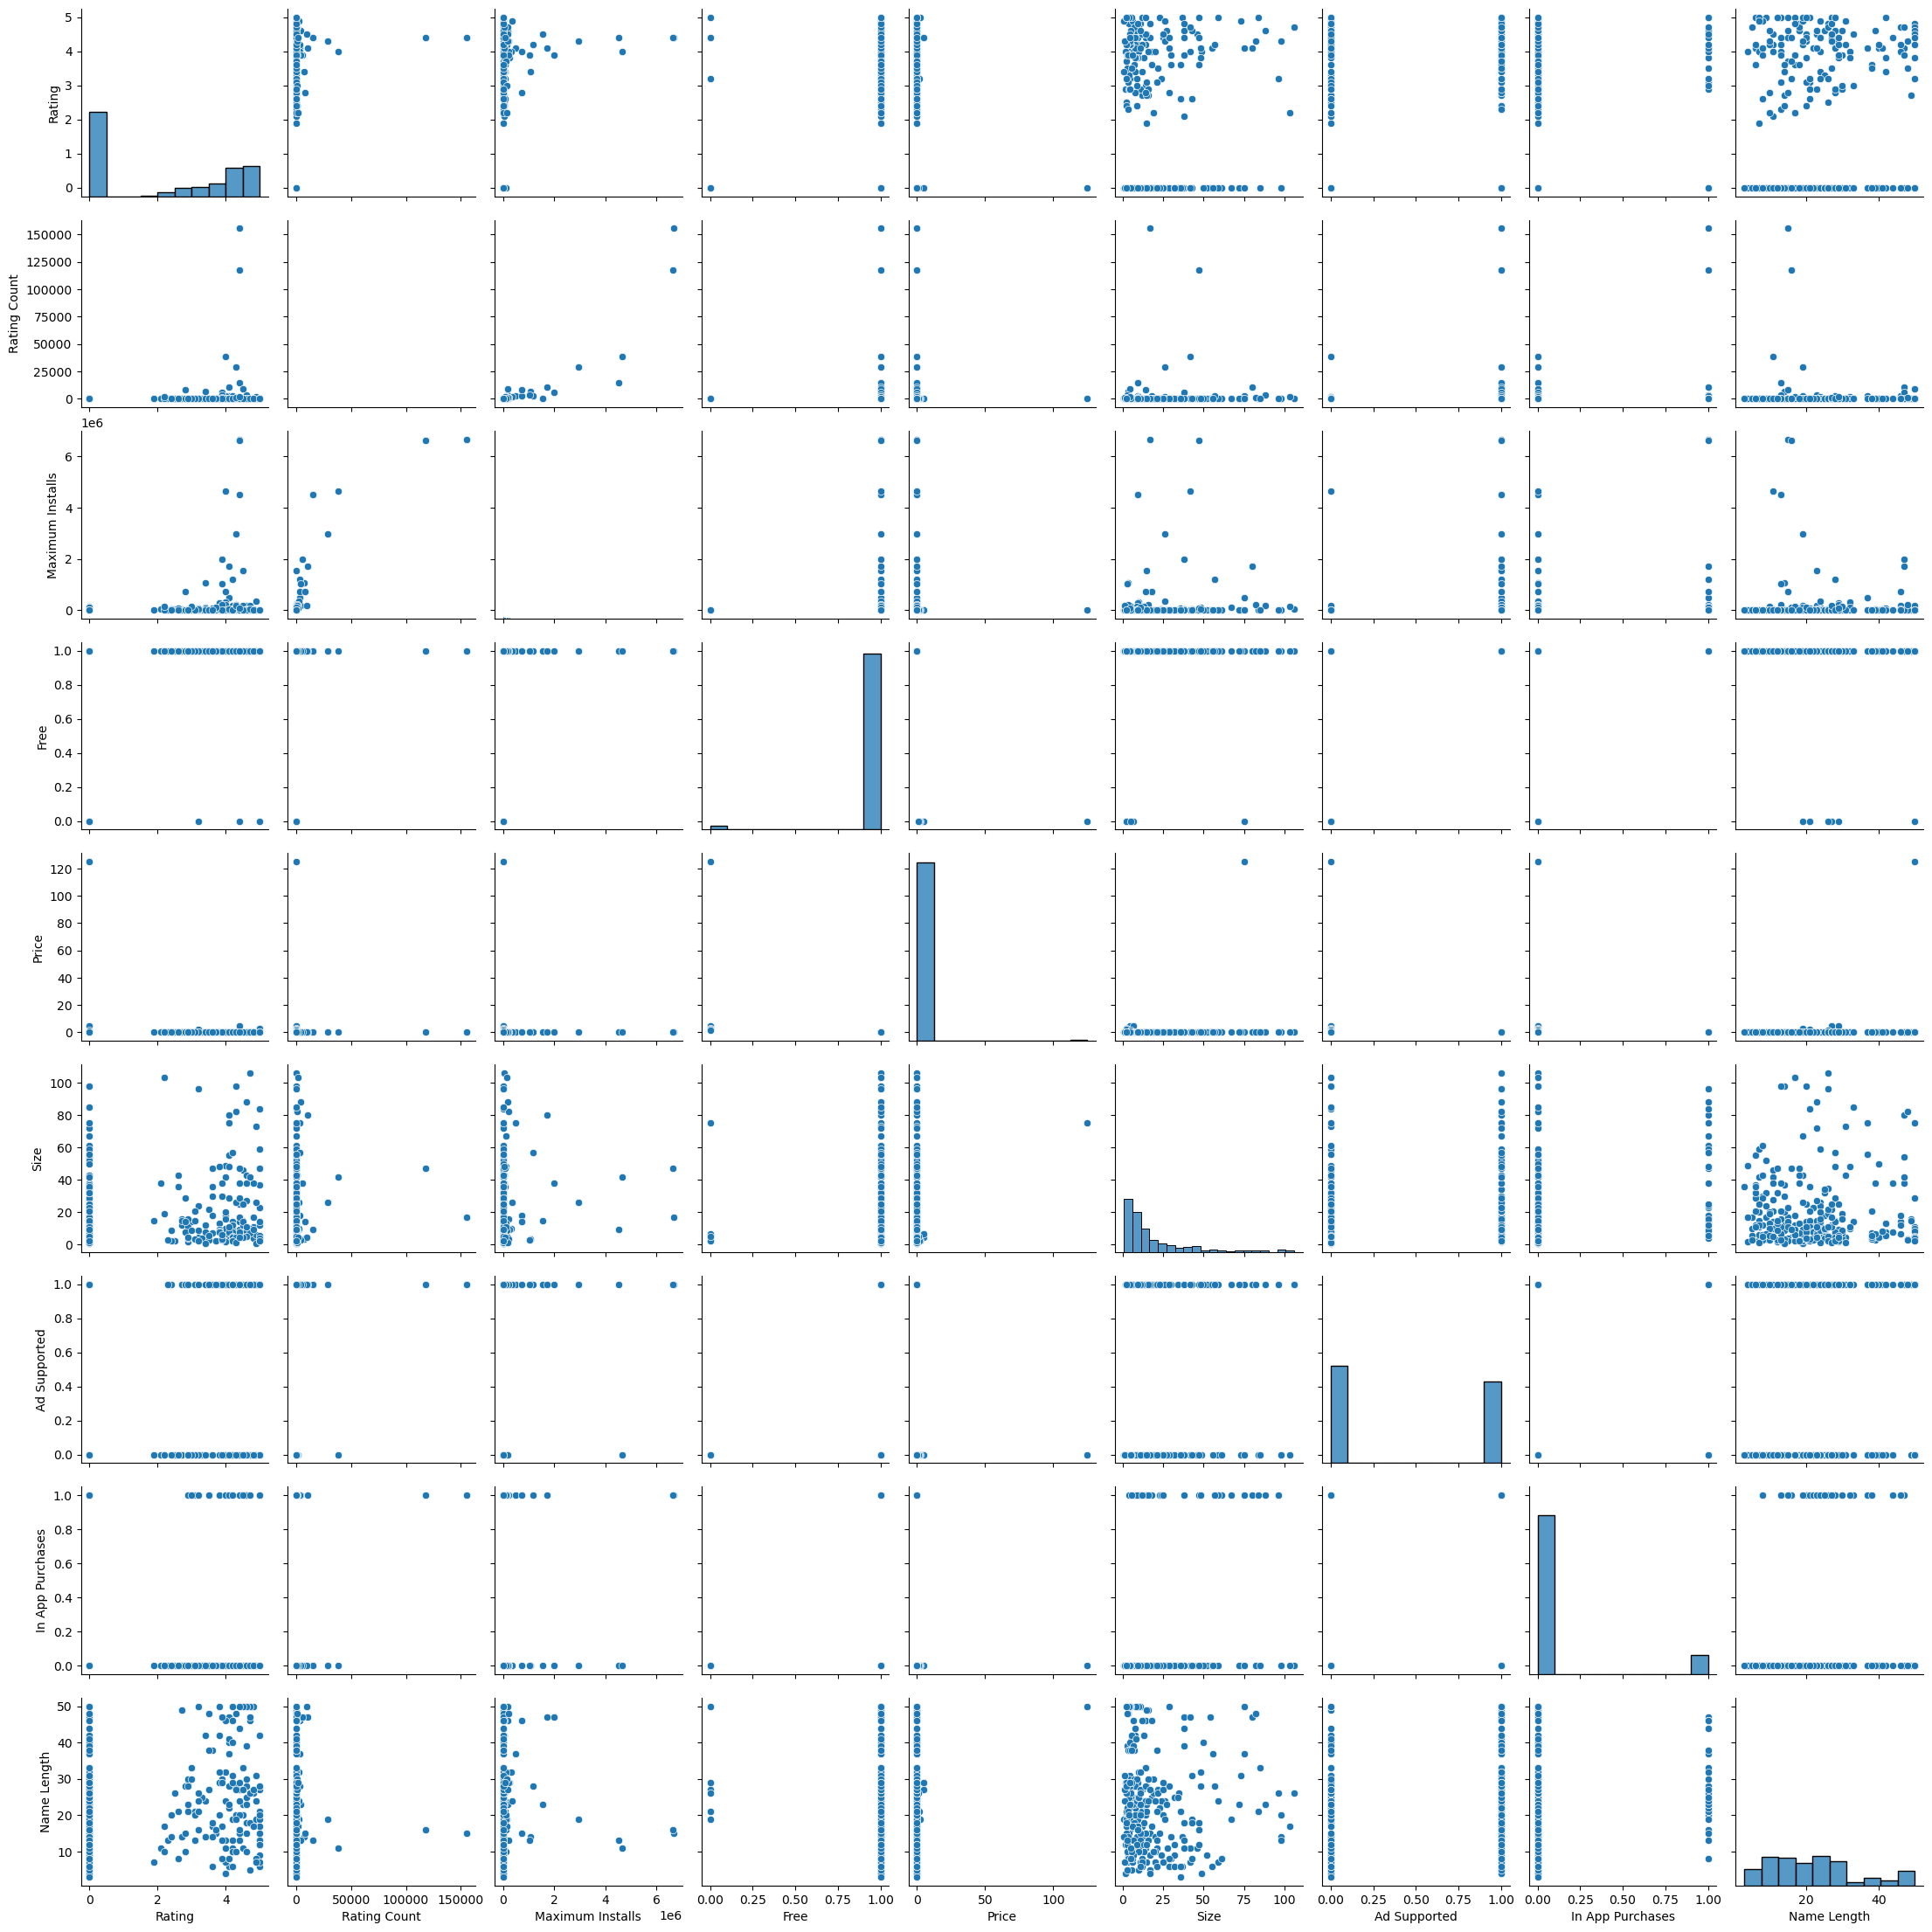

In [46]:
sns.pairplot(s_df)

In [54]:
# We can already filter on less than 100.000 installs and at least 10 ratings
df = df[(df['Maximum Installs'] < 100000) & (df['Rating Count'] >= 10)]
df['Rating Count'] = df['Rating Count'].astype(int)
df.shape

(806021, 19)

In [55]:
#Several columns are better log-transformed
log_transform_cols = ['Rating Count', 'Maximum Installs', 'Price', 'Size']
for col in log_transform_cols:
    df[col] = np.log10(df[col]+1)
    df = df.rename(columns={col:('log_'+col)})

In [107]:
p_df, s_df = train_test_split(df, test_size=300, random_state=123) #parked and small subset
sns.pairplot(s_df)

NameError: name 'train_test_split' is not defined

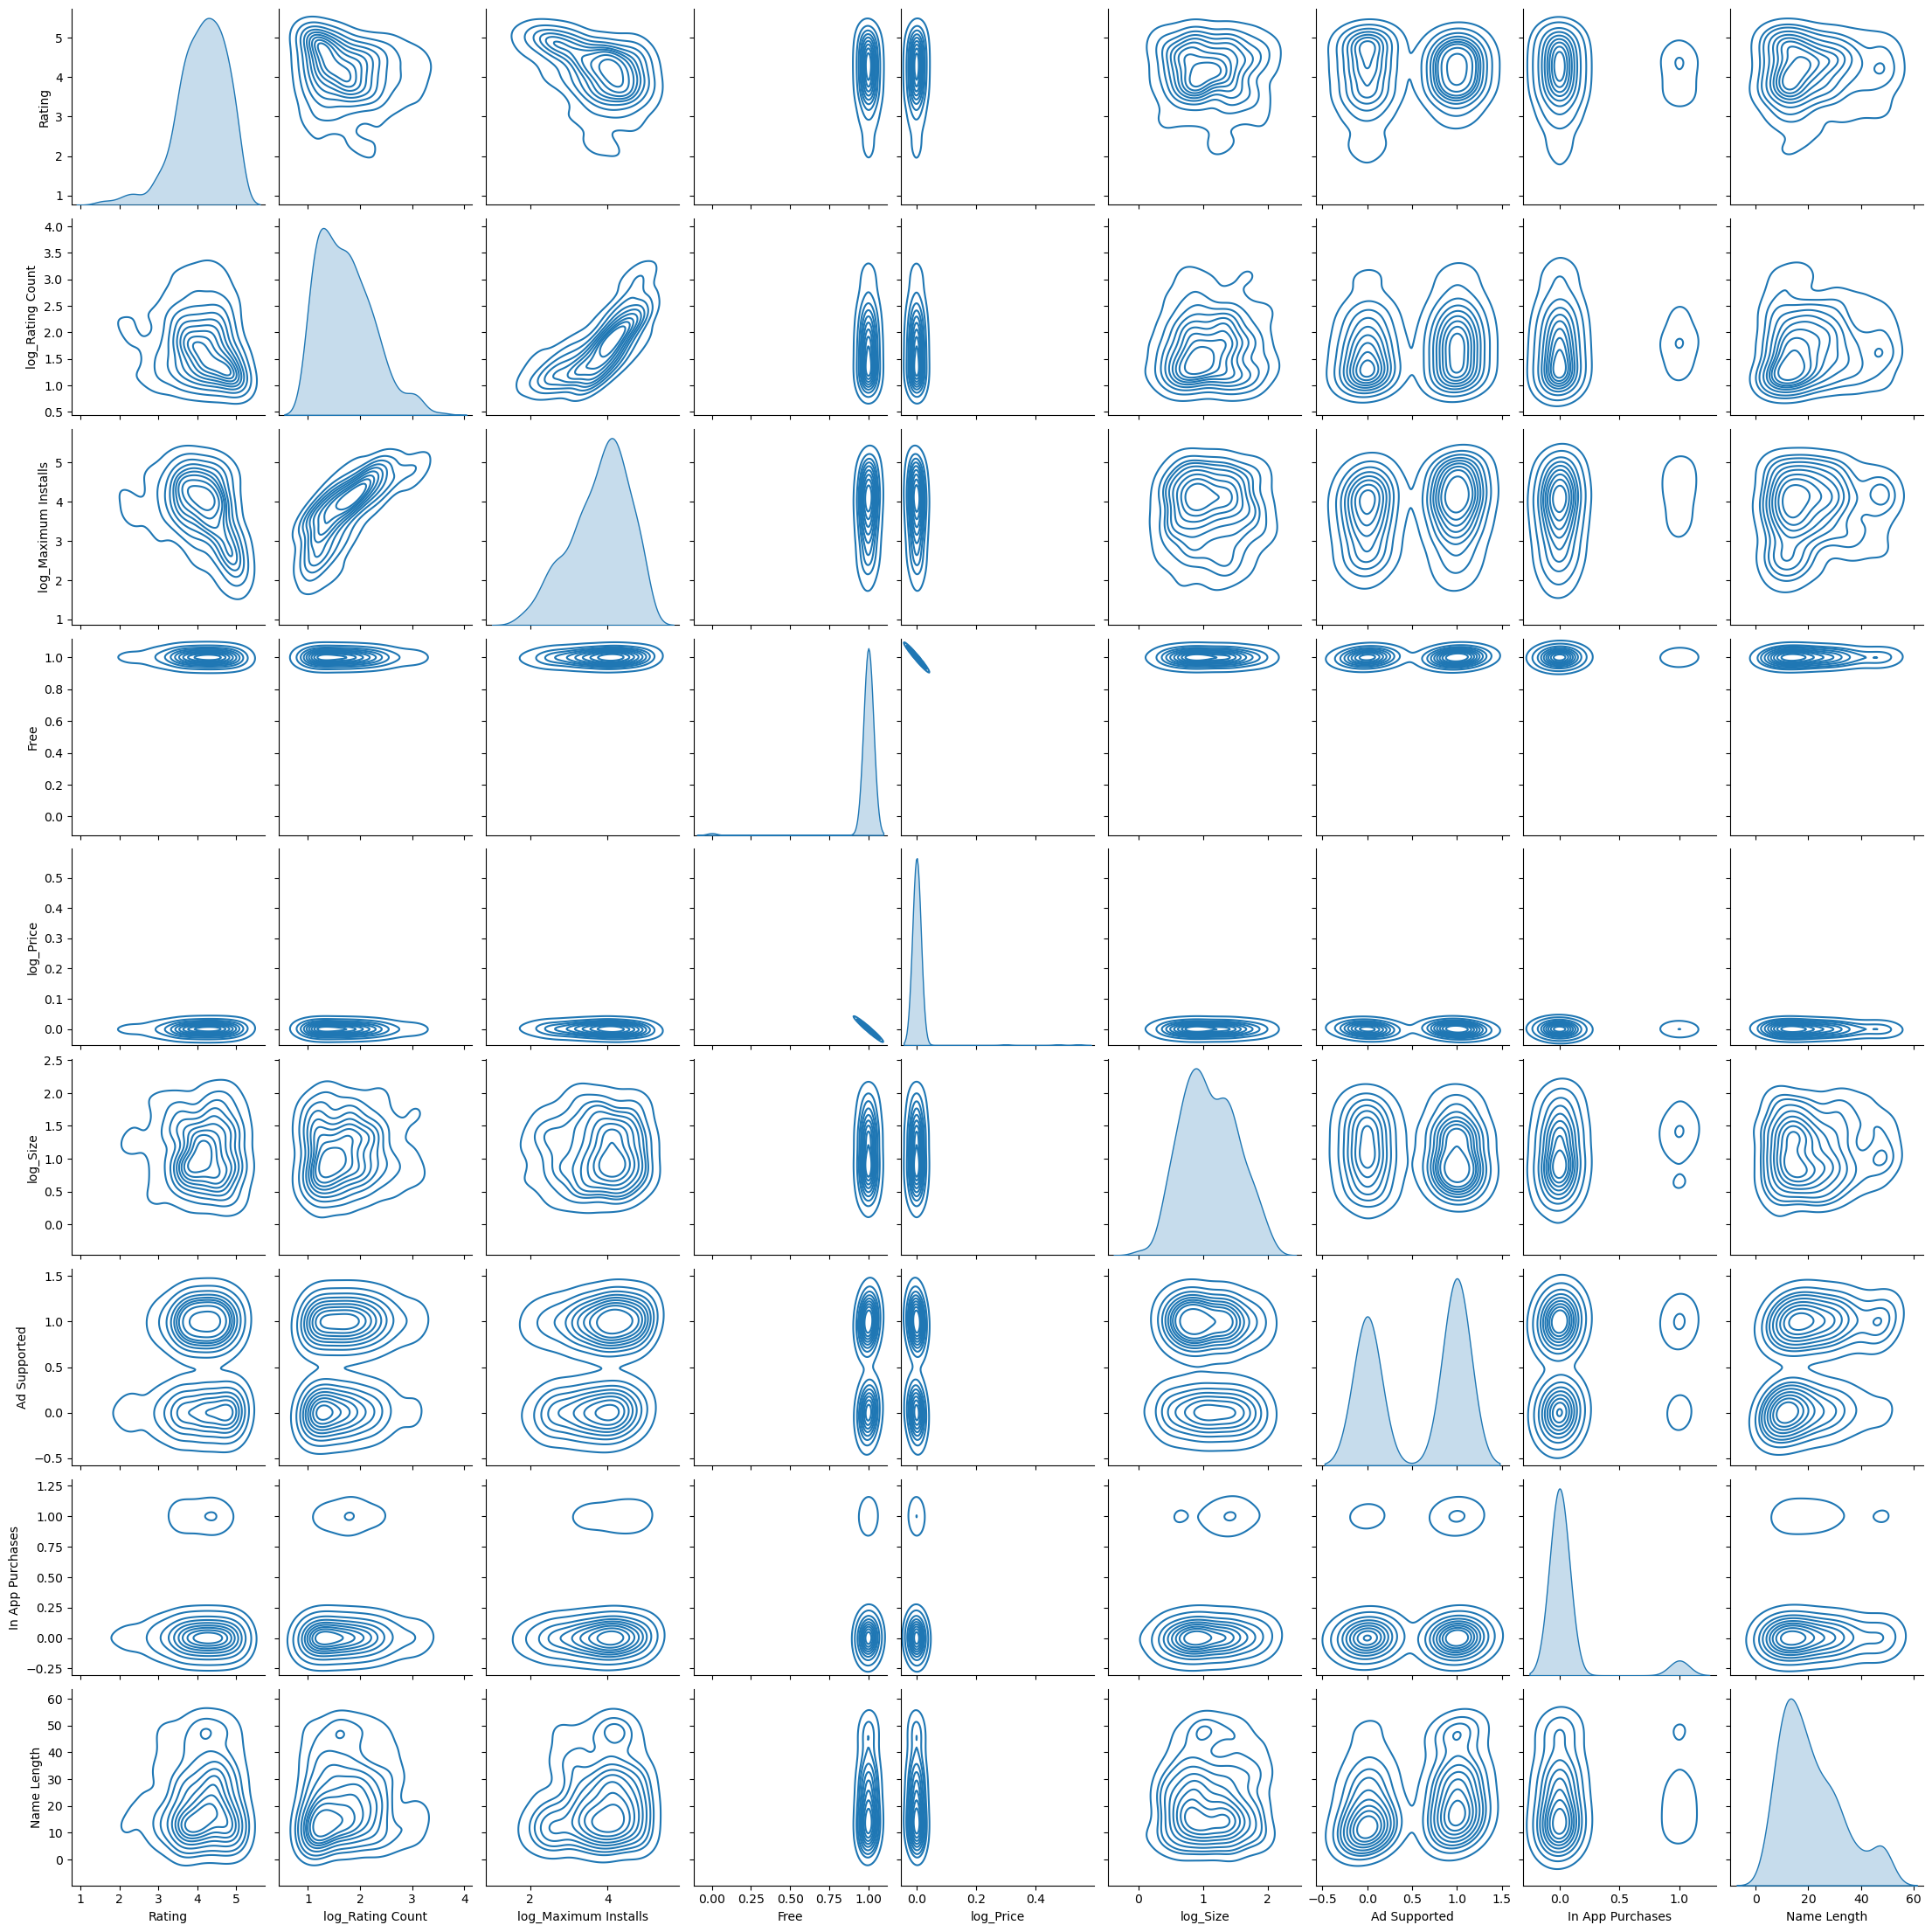

In [50]:
p_df, s_df = train_test_split(df, test_size=300, random_state=123) #parked and small subset
sns.pairplot(s_df, kind='kde')

                               Rating  log_Rating Count  log_Maximum Installs  \
log_Rating Count            -0.041813          1.000000              0.695492   
log_Maximum Installs        -0.299690          0.695492              1.000000   
log_Price                    0.013622          0.068148             -0.075712   
log_Size                     0.002658          0.067595             -0.001564   
Ad Supported                 0.072513          0.053459              0.180406   
In App Purchases            -0.016828          0.125504              0.093054   
Name Length                  0.055143          0.069077              0.137444   
Time since last update      -0.040979         -0.022131              0.006165   
Days Release to Last Update -0.076046          0.205399              0.208267   

                             log_Price  log_Size  Ad Supported  \
log_Rating Count              0.068148  0.067595      0.053459   
log_Maximum Installs         -0.075712 -0.001564      0.1

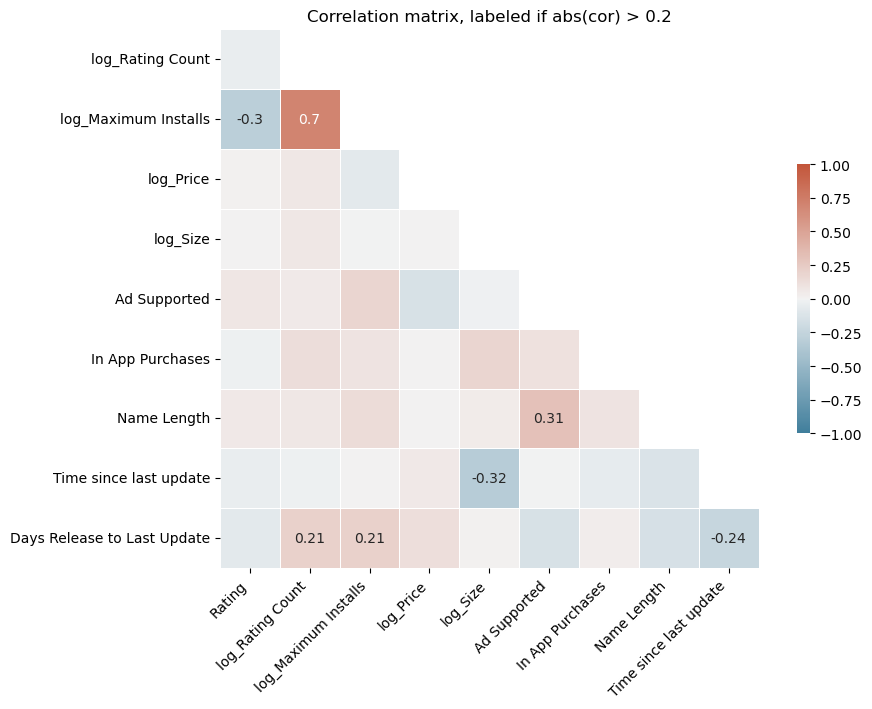

In [41]:
def correlation_matrix(df, cutoff, drop_cols=False, save_png=False):
    if drop_cols != False:
        df = df.drop(drop_cols, axis=1)
    #Correlation matrix
    df_corr = df.corr().iloc[1:, :-1]
    mask = np.triu(np.ones_like(df_corr, dtype=bool), 1)
    print(df_corr)
    fig,ax1 = plt.subplots(figsize=(6.4*1.5, 4.8*1.5))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    #Wacky solution because the first line gives a format erro
    annotations = df_corr.applymap(lambda x: round(x, 2) if abs(round(x, 2)) >= cutoff else '').astype(str)
    #annotations = np.array([[f'{df_corr.iloc[i, j]:.2f}' for j in range(df_corr.shape[0])] for i in range(df_corr.shape[1])])
    sns.heatmap(ax= ax1, data=df_corr, mask=mask, annot=annotations, fmt="", vmin=-1, vmax=1, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')
    #Rotating y labels is not as easy as copying the trick unfortunately
    #ax1.set_yticks(ax1.get_yticks(), ax1.get_yticklabels(), rotation=45, ha='right')
    ax1.set_title('Correlation matrix, labeled if abs(cor) > '+str(cutoff))
    plt.tight_layout()
    plt.show()
    if save_png:
        fig.savefig('./outputs/figures/correlation_matrix.png', transparent=False)
    return

correlation_matrix(df, 0.2, drop_cols=['Free'], save_png=True)

#Quick and dirty for comparison
#df_corr = df.corr()
#sns.heatmap(data=df_corr)


Known                 783378
Varies with device     22643
Name: Size Cat, dtype: int64


<AxesSubplot: title={'center': 'log_Maximum Installs'}, xlabel='Size Cat'>

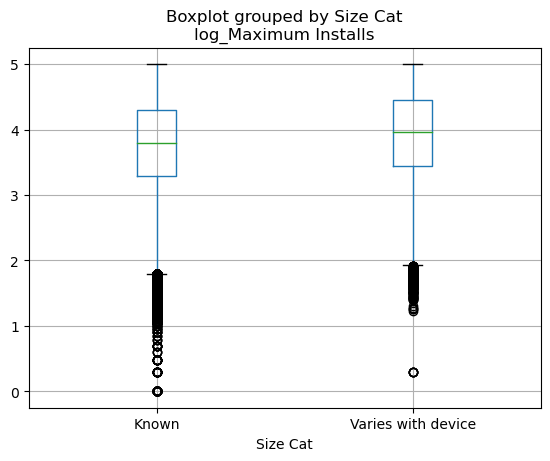

In [99]:
#Visualize max installs over different Size categories
print(df['Size Cat'].value_counts())
df.boxplot(column='log_Maximum Installs', by='Size Cat')

In [56]:
df = df.drop(['log_Size'], axis=1)

In [57]:
df = df.dropna()
print(df.shape)

(788927, 18)


In [53]:
df.head()

,App Name,App Id,Category,Rating,log_Rating Count,log_Maximum Installs,Free,log_Price,Released,Last Updated,Ad Supported,In App Purchases,Super Category,Rating Bin,Name Length,Size Cat
index,,,,,,,,,,,,,,,,
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,1.812913,3.884399,True,0.0,"May 21, 2020","May 06, 2021",True,False,Other,Moderate,19,Known
6,unlimited 4G data prank free app,getfreedata.superfatiza.unlimitedjiodataprank,Libraries & Demo,4.5,1.113943,3.409595,True,0.0,"Sep 23, 2019","Sep 27, 2019",True,False,Other,Superb,32,Known
7,The Everyday Calendar,com.mozaix.simoneboard,Lifestyle,2.0,1.602060,2.846955,True,0.0,"Jun 21, 2019","Jun 21, 2019",False,False,Personal & Social,Bad App Yo,21,Known
9,Neon 3d Iron Tech Keyboard Theme,com.ikeyboard.theme.neon_3d.iron.tech,Personalization,4.7,2.914343,4.795421,True,0.0,"Sep 22, 2019","Oct 07, 2020",True,False,Personal & Social,Superb,32,Known
10,Dodge The Cars!,com.MrScratchEnterprises.CarDogeGame,Racing,4.9,1.748188,2.518514,True,0.0,"Jul 30, 2020","Jul 30, 2020",False,False,Entertainment,Superb,15,Known


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 788927 entries, 1 to 2312943
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   App Name              788927 non-null  object  
 1   App Id                788927 non-null  object  
 2   Category              788927 non-null  object  
 3   Rating                788927 non-null  float64 
 4   log_Rating Count      788927 non-null  float64 
 5   log_Maximum Installs  788927 non-null  float64 
 6   Free                  788927 non-null  bool    
 7   log_Price             788927 non-null  float64 
 8   Released              788927 non-null  object  
 9   Last Updated          788927 non-null  object  
 10  Ad Supported          788927 non-null  bool    
 11  In App Purchases      788927 non-null  bool    
 12  Super Category        788927 non-null  category
 13  Rating Bin            788927 non-null  category
 14  Name Length           788927 non-nu

In [58]:
df['Rating Bin'].value_counts()

Superb        276811
Bad App Yo    261710
Moderate      250406
Name: Rating Bin, dtype: int64

**Code below is still in development**

In [56]:
def prepare_inputs(encoder_type, feature):
    try:
        ohe = encoder_type
        return df.join(pd.DataFrame(data=ohe.fit_transform(df[[feature]]).toarray(), dtype=np.int8, 
            columns=list(df[feature].unique())))
    except:
        print("Get right column")

# reset index to be able to perform the join
df = df.reset_index(drop=True)

# one hot encoder
df = prepare_inputs(sklearn.preprocessing.OneHotEncoder(), 'Rating Bin')
df = prepare_inputs(sklearn.preprocessing.OneHotEncoder(), 'Super Category')

In [57]:
df.columns

Index(['App Name', 'App Id', 'Category', 'Rating', 'log_Rating Count',
       'log_Maximum Installs', 'Free', 'log_Price', 'Released', 'Last Updated',
       'Ad Supported', 'In App Purchases', 'Super Category', 'Rating Bin',
       'Name Length', 'Size Cat', 'Moderate', 'Superb', 'Bad App Yo', 'Other',
       'Personal & Social', 'Entertainment', 'Development'],
      dtype='object')

In [59]:
df['Last Updated'] = pd.to_datetime(df['Last Updated'])
df['Released'] = pd.to_datetime(df['Released'])
df['Days Release to Last Update'] = (df['Last Updated'] - df['Released']).dt.days

In [59]:
df = df.drop(['Last Updated', 'Rating', 'Category', 'Super Category', 'Rating Bin', 'Other', 'Released'], axis=1)
# 'Rating Bin'

In [113]:
df.head()

,App Name,App Id,Category,Rating,log_Rating Count,log_Maximum Installs,Free,log_Price,log_Size,Released,Last Updated,Ad Supported,In App Purchases,Super Category,Rating Bin,Name Length,Size Cat,Time since last update,Days Release to Last Update
index,,,,,,,,,,,,,,,,,,,
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,1.812913,3.884399,True,0.0,0.591065,2020-05-21,2021-05-06,True,False,Other,Moderate,19,Known,0,350.0
6,unlimited 4G data prank free app,getfreedata.superfatiza.unlimitedjiodataprank,Libraries & Demo,4.5,1.113943,3.409595,True,0.0,0.544068,2019-09-23,2019-09-27,True,False,Other,Superb,32,Known,2,4.0
7,The Everyday Calendar,com.mozaix.simoneboard,Lifestyle,2.0,1.602060,2.846955,True,0.0,1.230449,2019-06-21,2019-06-21,False,False,Personal & Social,Bad App Yo,21,Known,2,0.0
9,Neon 3d Iron Tech Keyboard Theme,com.ikeyboard.theme.neon_3d.iron.tech,Personalization,4.7,2.914343,4.795421,True,0.0,0.653213,2019-09-22,2020-10-07,True,False,Personal & Social,Superb,32,Known,1,381.0
10,Dodge The Cars!,com.MrScratchEnterprises.CarDogeGame,Racing,4.9,1.748188,2.518514,True,0.0,1.716003,2020-07-30,2020-07-30,False,False,Entertainment,Superb,15,Known,1,0.0


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788927 entries, 0 to 788926
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   App Name                     788927 non-null  object 
 1   App Id                       788927 non-null  object 
 2   log_Rating Count             788927 non-null  float64
 3   log_Maximum Installs         788927 non-null  float64
 4   Free                         788927 non-null  bool   
 5   log_Price                    788927 non-null  float64
 6   Ad Supported                 788927 non-null  bool   
 7   In App Purchases             788927 non-null  bool   
 8   Name Length                  788927 non-null  int64  
 9   Size Cat                     788927 non-null  object 
 10  Moderate                     788927 non-null  int8   
 11  Superb                       788927 non-null  int8   
 12  Bad App Yo                   788927 non-null  int8   
 13 

In [62]:
df.to_parquet('data\Google-Playstore-Modified_L.parquet')

In [221]:
def perform_pca (df, quanti_vars, quali_vars, n_components='all', palette=None):
    """
    Perform PCA
    Input:
    df - pandas DataFrame
    quanti_vars - list of quantitative variable names in df, used as original dimension in transformation
    quali_vars - list of qualitative variable names in df, used to color
    n_components - number of principal components to fit. Strongly recommended to leave at 'all' because percentage variance explained currently relies on this.

    Result:
    For each qualitative variable a figure with subplots of the first few PCs against each other, but only if the number of unique colors is limited.
    Printed list of variance explained for each PC.
    Several progress and internal decision prints.
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    scaler = StandardScaler()
    quanti_df = df[quanti_vars]
    quali_df = df[quali_vars]
    scaler.fit(quanti_df)
    scaled_qdf = scaler.transform(quanti_df)

    if n_components == 'all':
        n_components = len(quanti_vars)
    else:
        n_components = int(n_components)

    pca = PCA(n_components=n_components)
    pca.fit(scaled_qdf)

    x_pca = pca.transform(scaled_qdf)
    print(scaled_qdf.shape)
    print(x_pca.shape)

    pcs_oi = [[1,2], [3,4], [1,3], [2,3]] #principal components of interest
    pcs_opi = [1,3] #principal components of particular interest

    for quali_var_oi in quali_vars:
        quali_values = len(quali_df[quali_var_oi].value_counts())
        print(quali_var_oi, 'unique values: ', quali_values)
        if 1 < quali_values < 11: #this needs to be extended, e.g. to 10 colors by making a predefined colormap
            pca_fig, axs = plt.subplots(nrows = len(pcs_oi)//2, ncols=2, figsize=(10, 10))
            for i in range(len(pcs_oi)):
                #sns.jointplot(ax=axs[i//2, i%2], x = x_pca[:,pcs_oi[i][0]-1], y= x_pca[:,pcs_oi[i][1]-1], hue=quali_df[quali_var_oi], palette=palette, alpha=0.4, kind='scatter')
                #sns.kdeplot(ax=axs[i//2, i%2], x = x_pca[:,pcs_oi[i][0]-1], y= x_pca[:,pcs_oi[i][1]-1], hue=quali_df[quali_var_oi], fill=True, palette=palette, levels=quali_values, alpha=0.33)
                sns.scatterplot(ax=axs[i//2, i%2], x = x_pca[:,pcs_oi[i][0]-1], y= x_pca[:,pcs_oi[i][1]-1], hue=quali_df[quali_var_oi], palette=palette, alpha=0.7)
                #axs[i//2, i%2].scatter(x_pca[:,pcs_oi[i][0]-1],x_pca[:,pcs_oi[i][1]-1], c=pd.factorize(cat_df[cat_var_oi]), color_map='Viridis')
                axs[i//2, i%2].set_xlabel('PC'+str(pcs_oi[i][0]))
                axs[i//2, i%2].set_ylabel('PC'+str(pcs_oi[i][1]))
            pca_fig.suptitle('PCA, color by: '+ quali_var_oi)
            pca_fig.tight_layout()
            pca_fig.savefig('./outputs/figures/pca_color_by_'+quali_var_oi+'.png')

            x = x_pca[:,pcs_opi[0]-1]
            y= x_pca[:,pcs_opi[1]-1]
            temp_df = pd.DataFrame({('PC'+str(pcs_opi[0])):x, ('PC'+str(pcs_opi[1])):y, quali_var_oi:quali_df[quali_var_oi]})
            print(temp_df.head())
            sns.jointplot(data=temp_df, x=('PC'+str(pcs_opi[0])), y=('PC'+str(pcs_opi[1])), hue=quali_var_oi, palette=palette, alpha=0.4, kind='scatter')
            #pca_fig2.savefig('./outputs/figures/pca_color_by_'+quali_var_oi+'_particular_interest.png')


    pcs_explained_var = pca.explained_variance_
    pcs_explained_var_perc = [float('%.2f' % (i / sum(pcs_explained_var))) for i in pcs_explained_var]
    print(pcs_explained_var_perc)
    return

(500, 6)
(500, 6)
Rating Bin unique values:  3
                         PC1       PC3  Rating Bin
Rating Bin index                                  
Bad App Yo 578765  -1.960396  0.505149  Bad App Yo
           2221841  0.571890 -1.847091  Bad App Yo
           1590415  1.874608 -0.756092  Bad App Yo
           1704762  0.423880 -1.309845  Bad App Yo
           987115  -0.374198  0.401156  Bad App Yo
[0.31, 0.2, 0.18, 0.17, 0.1, 0.05]


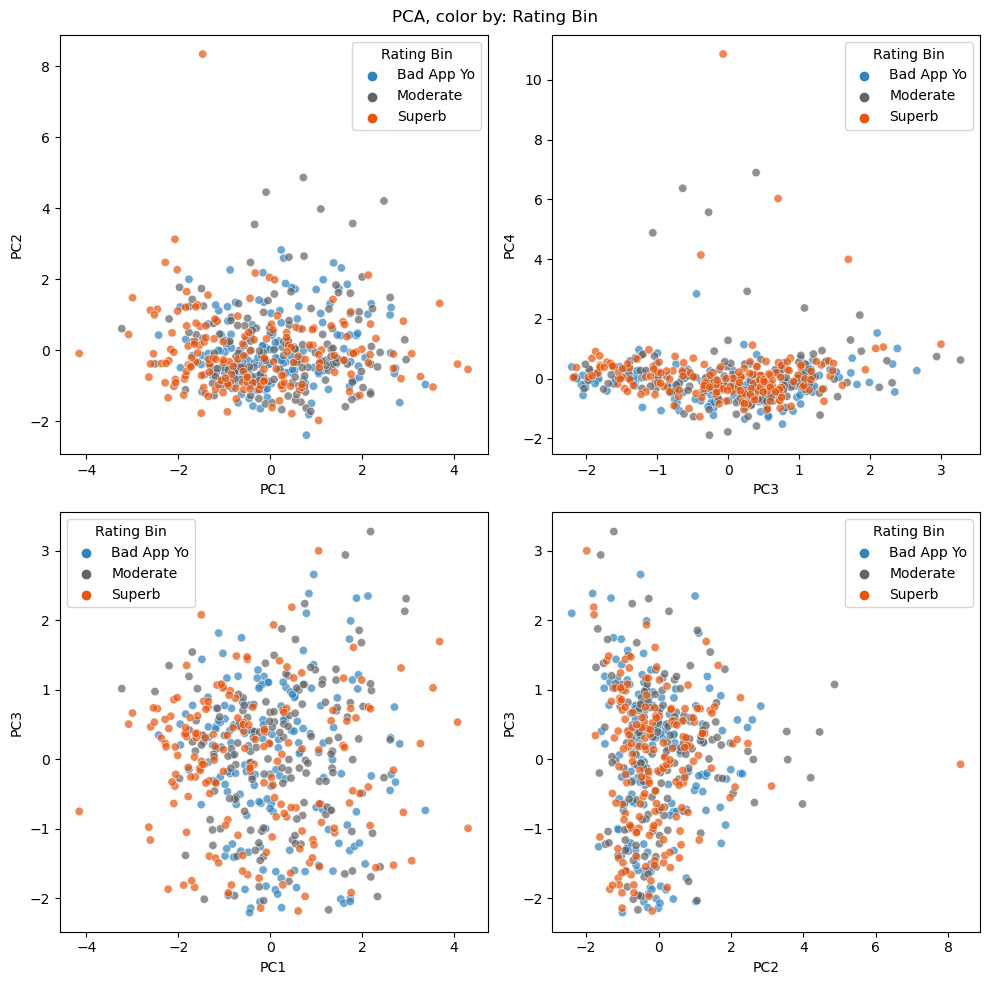

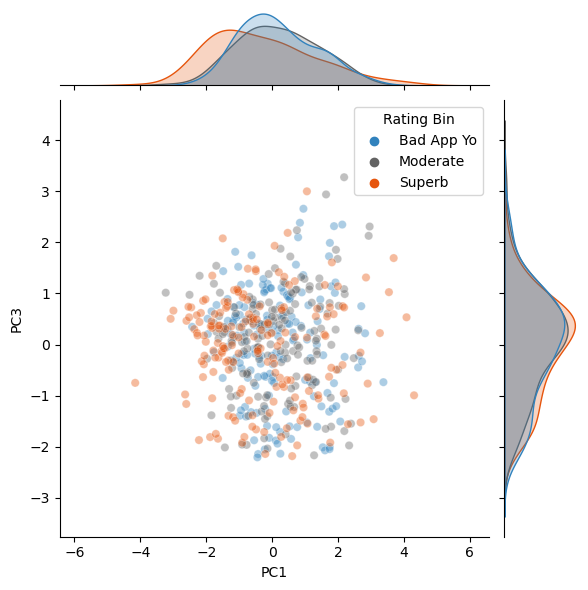

In [222]:
from matplotlib.cm import get_cmap

df.head()
#quanti_vars = ['log_Rating Count', 'log_Maximum Installs', 'log_Price', 'log_Size', 'Name Length','Time since last update','Days Release to Last Update']
quanti_vars = ['log_Rating Count', 'log_Maximum Installs', 'log_Price', 'Name Length','Time since last update', 'Days Release to Last Update']
#quali_vars = ['Free', 'Ad Supported', 'In App Purchases', 'Super Category', 'Rating Bin', 'Size Cat']
quali_vars = ['Rating Bin']
cmap = get_cmap('tab20c')
palette = {'Bad App Yo':cmap(0), 'Moderate':cmap(16), 'Superb':cmap(4)}

#plt.cm.tab20c(0), plt.cm.tab20c(7), plt.cm.tab20c(4)
s_df = sample_df(df, sample_size=500, strat_column='Rating Bin')
perform_pca(s_df, quanti_vars, quali_vars, palette=palette)

In [49]:
s_df.shape

(301, 19)